# Chapter 3 - Linear Regression
- [3.1 Simple Linear Regression](#Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#Multiple-Linear-Regression)
- [3.3 Other Considerations in the Regression Model](#Other-Considerations-in-the-Regression-Model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import statsmodels.api as sm
from patsy import dmatrices

In [3]:
filename = '../data/advertising.csv'
advertising_df = pd.read_csv(filename, index_col=0)

In [4]:
advertising_df.shape

(200, 4)

In [5]:
advertising_df.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [6]:
advertising_df.tail()

,TV,Radio,Newspaper,Sales
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5
200,232.1,8.6,8.7,13.4


In [7]:
advertising_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


In [8]:
advertising_df.describe().applymap('{:.2f}'.format)

,TV,Radio,Newspaper,Sales
count,200.00,200.00,200.00,200.00
mean,147.04,23.26,30.55,14.02
std,85.85,14.85,21.78,5.22
min,0.70,0.00,0.30,1.60
25%,74.38,9.97,12.75,10.38
50%,149.75,22.90,25.75,12.90
75%,218.82,36.52,45.10,17.40
max,296.40,49.60,114.00,27.00


In [9]:
advertising_df.isna().any()

TV           False
Radio        False
Newspaper    False
Sales        False
dtype: bool

## Simple Linear Regression

In [10]:
y, X = dmatrices('Sales ~ TV', data=advertising_df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()

### Figure 3.1

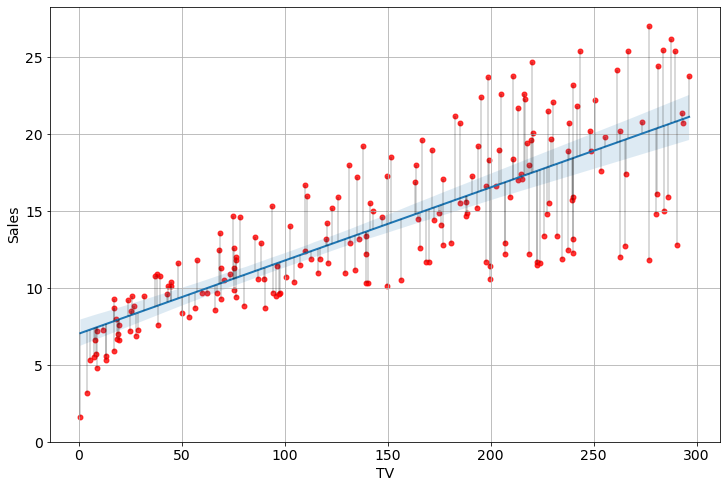

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
fs = 14
# using seaborn
sns.regplot(x='TV', y='Sales', data=advertising_df, scatter_kws={'color':'r', 's':24}, order=1,
            truncate=True, line_kws={'lw': 2}, ci=99, ax=ax)
# using 'import statsmodels.api as sm' for linear fit model
# using res.params[0] for intercept and res.params[1] for slope
for i in range(advertising_df.shape[0]):
    x_data = advertising_df['TV'].iloc[i]
    y_data = advertising_df['Sales'].iloc[i]
    y_pred = res.params[0]+res.params[1]*x_data
    ax.vlines(x=x_data, ymin=y_pred, ymax=y_data, lw=0.3, color='k')
ax.set_xlabel('TV', fontsize=fs)
ax.set_ylim(bottom=0)
ax.set_ylabel('Sales', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid(True);

### Figure 3.2

In [12]:
from sklearn.preprocessing import scale
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
# Regression coefficients with OLS (Ordinary Least Squares)
regr = lm.LinearRegression()

X = scale(advertising_df['TV'], with_mean=True, with_std=False).reshape(-1,1)
y = advertising_df['Sales']

regr.fit(X,y)
print("Intercept: {:1.4f}".format(regr.intercept_))
print("Slope: {:1.4f}".format(regr.coef_[0]))

Intercept: 14.0225
Slope: 0.0475


In [14]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-3, regr.intercept_+3, 50)
B1 = np.linspace(regr.coef_-0.03, regr.coef_+0.03, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B1.size, B0.size))

# Calculate Z-values (RSS) based on a grid of coefficients
for (i, j), v in np.ndenumerate(Z):
    Z[i, j] = ((y - (xx[i, j]+X.ravel()*yy[i, j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1, 1))**2)/1000
print("Minimum value for sum of the residuals squared: {:1.4f}".format(min_rss))
print("Residual standard error: {:1.4f}".format(np.sqrt(1000*min_rss/(X.shape[0]-2))))

Minimum value for sum of the residuals squared: 2.1025
Residual standard error: 3.2587


In [15]:
print("Residual standard error: {:1.4f}".format(np.sqrt(((y - regr.predict(X))**2).sum()/(X.shape[0]-2))))
print("R-squared: {:1.4f}".format(regr.score(X, y)))

Residual standard error: 3.2587
R-squared: 0.6119


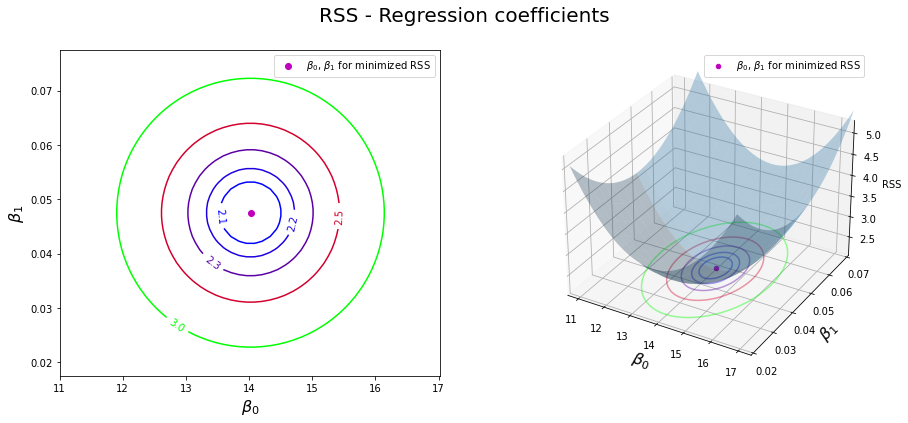

In [16]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
cs = ax1.contour(xx, yy, Z, cmap=plt.cm.brg, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='m', label=min_RSS)
ax1.clabel(cs, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.brg,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='m', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=16)
    ax.set_ylabel(r'$\beta_1$', fontsize=16)
    ax.set_xticks([11,12,13,14,15,16, 17])
    ax.set_yticks([0.02,0.03,0.04,0.05,0.06,0.07])
    ax.legend()

### Table 3.1

In [17]:
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


### Table 3.2

#### _statsmodels_

In [18]:
res.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.612
Model:,OLS,Adj. R-squared:,0.610
Method:,Least Squares,F-statistic:,312.1
Date:,"Thu, 16 Dec 2021",Prob (F-statistic):,1.47e-42
Time:,16:47:44,Log-Likelihood:,-519.05
No. Observations:,200,AIC:,1042.
Df Residuals:,198,BIC:,1049.
Df Model:,1,,
Covariance Type:,nonrobust,,


In [19]:
print("R-squared: {:1.4f}".format(res.rsquared))

R-squared: 0.6119


In [20]:
print("F-statistic: {:1.4f}".format(res.fvalue))

F-statistic: 312.1450


In [21]:
dof = len(advertising_df['TV']) - 2
sum_res = ((advertising_df['Sales'] - (res.params[0] + res.params[1]*advertising_df['TV']))**2).sum()
rse = np.sqrt(sum_res/dof)
print("Residual standard error: {:1.4f}".format(rse))

Residual standard error: 3.2587


In [22]:
print("Residual standard error: {:1.4f}".format(np.sqrt(res.mse_resid)))

Residual standard error: 3.2587


#### _scikit-learn_

In [23]:
regr = lm.LinearRegression()
X = advertising_df.TV.values.reshape(-1,1)
y = advertising_df.Sales
regr.fit(X, y)

LinearRegression()

In [24]:
print("R-squared: {:1.4f}".format(r2_score(y, regr.predict(X))))

R-squared: 0.6119


In [25]:
# k: corrective factor from mean squared error to residual standard error
k = (np.sqrt(X.shape[0]/(X.shape[0]-2)))
print("Residual standard error: {:1.4f}".format(k*np.sqrt(mean_squared_error(y, regr.predict(X)))))

Residual standard error: 3.2587


## Multiple Linear Regression

### Table 3.3

In [26]:
y, X = dmatrices('Sales ~ Radio', data=advertising_df, return_type='dataframe')
res = sm.OLS(y, X).fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
Radio,0.2025,0.020,9.921,0.000,0.162,0.243


In [27]:
y, X = dmatrices('Sales ~ Newspaper', data=advertising_df, return_type='dataframe')
res = sm.OLS(y, X).fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


### Table 3.4

In [28]:
y, X = dmatrices('Sales ~ TV + Radio + Newspaper', data=advertising_df, return_type='dataframe')
print('y', y.shape)
print('X', X.shape)
res = sm.OLS(y, X).fit()
res.summary().tables[1]

y (200, 1)
X (200, 4)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
Radio,0.1885,0.009,21.893,0.000,0.172,0.206
Newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


### Table 3.5

In [29]:
advertising_corr_df = advertising_df.corr().applymap('{:1.4f}'.format)
advertising_corr_df.where(np.triu(np.ones(advertising_corr_df.shape)).astype('bool'))

,TV,Radio,Newspaper,Sales
TV,1.0000,0.0548,0.0566,0.7822
Radio,NaN,1.0000,0.3541,0.5762
Newspaper,NaN,NaN,1.0000,0.2283
Sales,NaN,NaN,NaN,1.0000


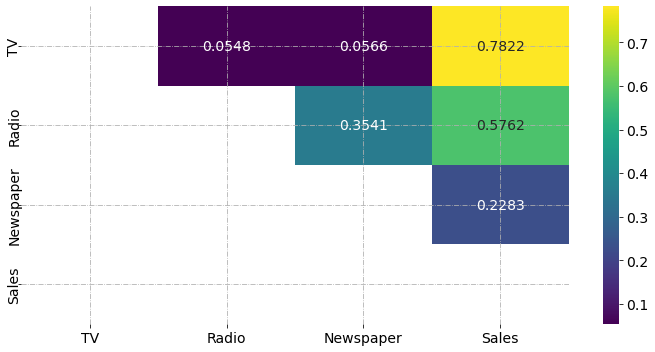

In [30]:
fig, axes = plt.subplots(figsize=(10, 5))
fs = 14
mask = np.zeros_like(advertising_df.corr())
mask[np.tril_indices_from(mask)] = True
hm = sns.heatmap(data=advertising_df.corr(), cmap='viridis', ax=axes, annot=True, fmt='1.4f', mask=mask, \
            annot_kws={'size':fs})
axes.tick_params(labelsize=fs)
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=fs)
plt.setp(axes.get_yticklabels(), ha="center", rotation_mode="anchor")
plt.tight_layout()
plt.grid(True, linestyle='-.');

### Table 3.6

In [31]:
res.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.897
Model:,OLS,Adj. R-squared:,0.896
Method:,Least Squares,F-statistic:,570.3
Date:,"Thu, 16 Dec 2021",Prob (F-statistic):,1.58e-96
Time:,16:47:44,Log-Likelihood:,-386.18
No. Observations:,200,AIC:,780.4
Df Residuals:,196,BIC:,793.6
Df Model:,3,,
Covariance Type:,nonrobust,,


### Figure 3.5

In [32]:
regr = lm.LinearRegression()
y, X = advertising_df['Sales'].values, advertising_df[['Radio', 'TV']].values
regr.fit(X, y)
print(r'Intercept: {:1.3f}'.format(regr.intercept_))
print(r'beta_0: {:1.3f}, beta_1: {:1.3f}'.format(regr.coef_[0], regr.coef_[1]))

Intercept: 2.921
beta_0: 0.188, beta_1: 0.046


In [33]:
x_rd = np.linspace(0, 50, 50)
x_tv = np.linspace(0, 300, 300)
X1, X2 = np.meshgrid(x_rd, x_tv, indexing='xy')
Y = np.zeros((x_tv.size, x_rd.size))

for (i, j), v in np.ndenumerate(Y):
    Y[i, j] = regr.intercept_ + regr.coef_[0]*X1[i, j] + regr.coef_[1]*X2[i, j]

/var/folders/w0/ckfnw4ss7zlbwfmw_477n1bc0000gn/T/ipykernel_73492/1024879266.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


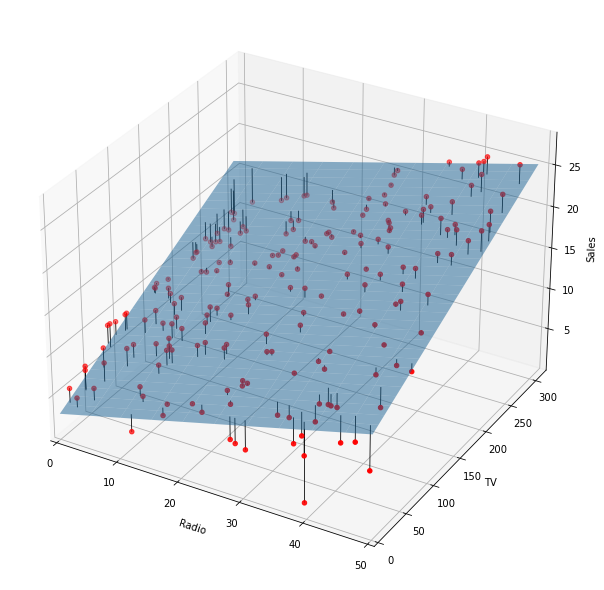

In [34]:
fig = plt.figure(figsize=(12, 8))
ax = axes3d.Axes3D(fig)

ax.plot_surface(X1, X2, Y, rstride=10, cstride=5, alpha=0.5)
ax.scatter3D(advertising_df['Radio'], advertising_df['TV'], advertising_df['Sales'], c='r')

for i in range(advertising_df.shape[0]):
    x1_data = advertising_df['Radio'].iloc[i]
    x2_data = advertising_df['TV'].iloc[i]
    y_data = advertising_df['Sales'].iloc[i]
    y_pred = regr.intercept_ + regr.coef_[0]*x1_data + regr.coef_[1]*x2_data
    ax.plot((x1_data, x1_data), (x2_data, x2_data), zs=(y_pred, y_data), color='k', lw=0.8)

ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(bottom=0)
ax.set_zlabel('Sales');

## Other Considerations in the Regression Model

### Figure 3.6

In [35]:
filename = '../data/credit.csv'
credit_df = pd.read_csv(filename, index_col=0)

In [36]:
credit_df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [37]:
cols = ['Balance', 'Age', 'Cards', 'Education', 'Income', 'Limit', 'Rating', 'Gender', 'Ethnicity']

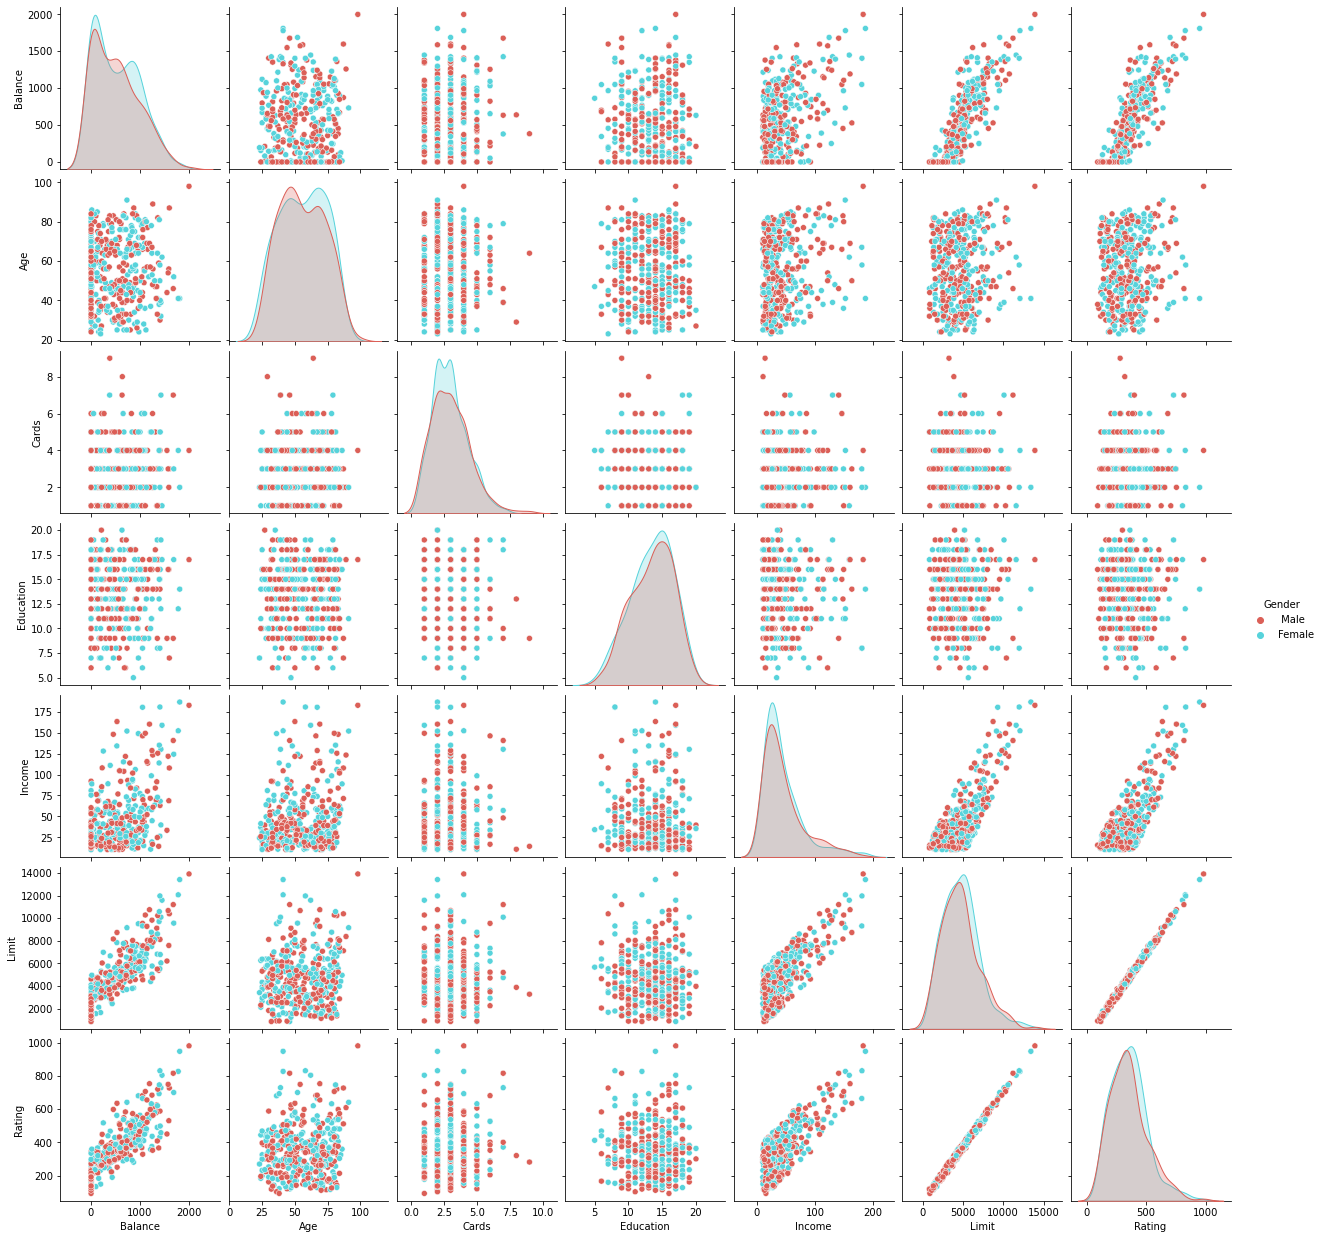

In [38]:
sns.pairplot(data=credit_df[cols], hue='Gender', palette='hls');

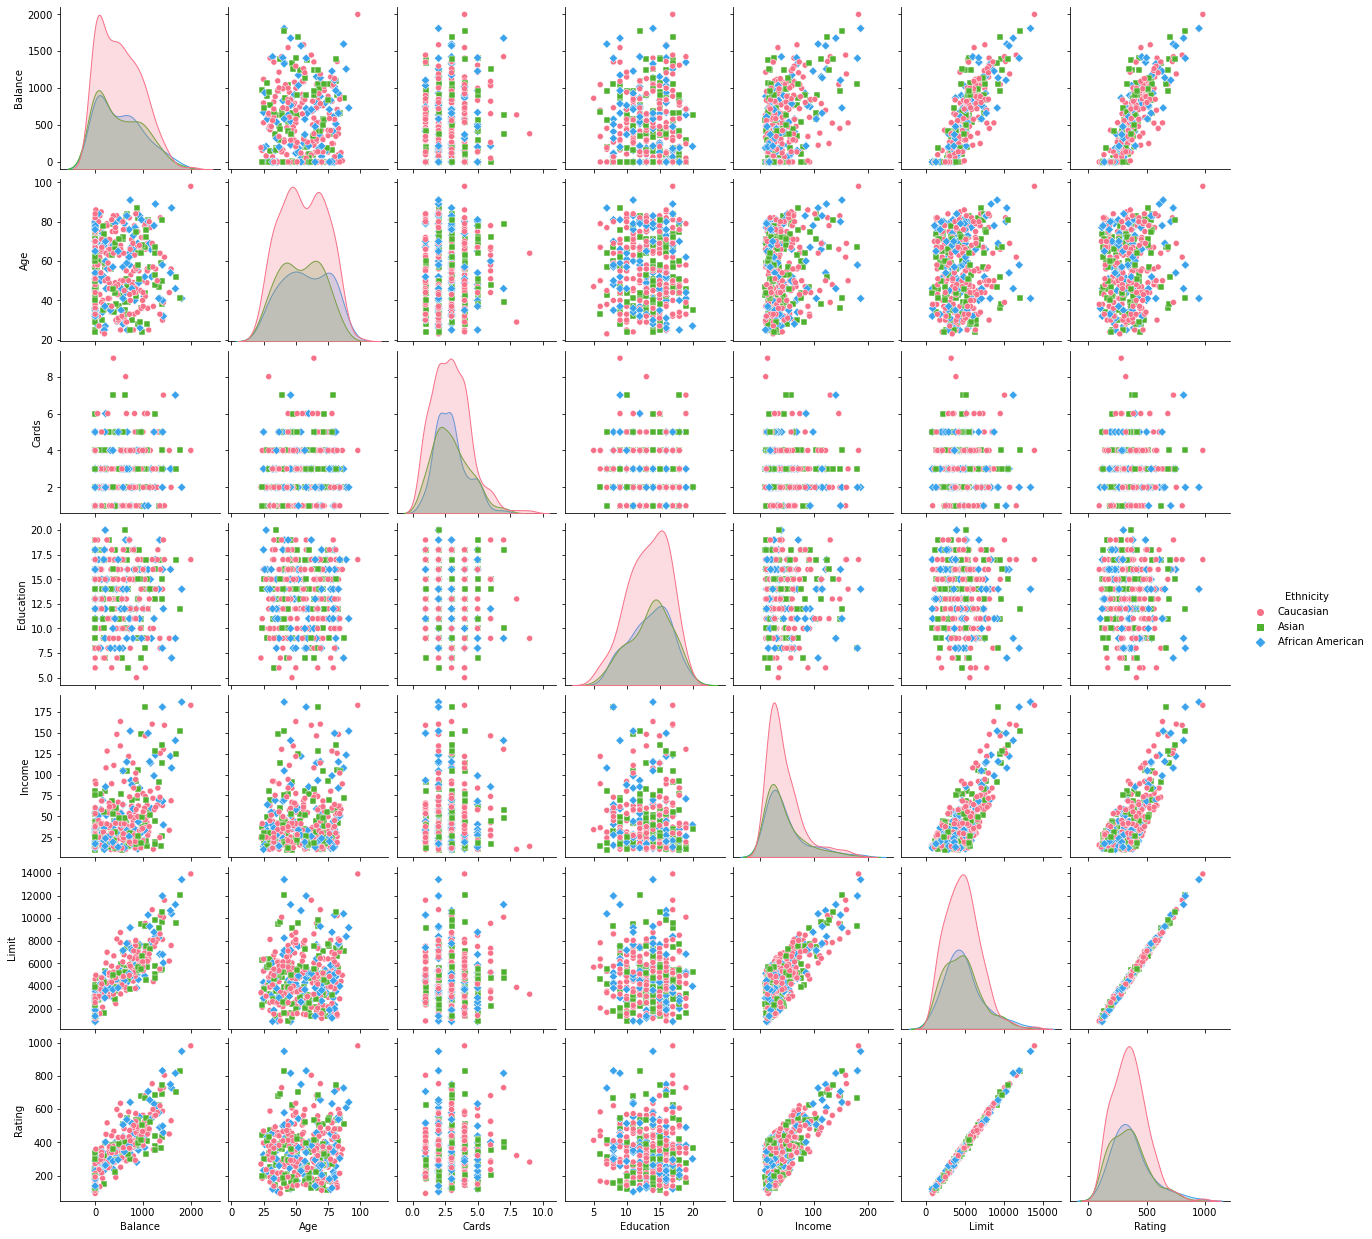

In [39]:
sns.pairplot(data=credit_df[cols], hue='Ethnicity', palette='husl', markers=["o", "s", "D"]);

### Table 3.7

In [40]:
y, X = dmatrices('Balance ~ Gender', data=credit_df, return_type='dataframe')
res = sm.OLS(y, X).fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,509.8031,33.128,15.389,0.000,444.675,574.931
Gender[T.Female],19.7331,46.051,0.429,0.669,-70.801,110.267


Due to the large p-values, no statistical evidence for a difference in average credit card balance exists between the genders.

### Table 3.8

In [41]:
y, X = dmatrices('Balance ~ Ethnicity', data=credit_df, return_type='dataframe')
res = sm.OLS(y, X).fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,531.0000,46.319,11.464,0.000,439.939,622.061
Ethnicity[T.Asian],-18.6863,65.021,-0.287,0.774,-146.515,109.142
Ethnicity[T.Caucasian],-12.5025,56.681,-0.221,0.826,-123.935,98.930


Due to the large p-values here, there is no statistical evidence for a difference in average credit card balance between ethnicities.

### Table 3.9

In [42]:
y, X = dmatrices('Sales ~ TV + Radio + TV * Radio', data=advertising_df, return_type='dataframe')
res = sm.OLS(y, X).fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


### Figure 3.7

In [43]:
y1, X1 = dmatrices('Balance ~ Income + Student', data=credit_df, return_type='dataframe')
res1 = sm.OLS(y1, X1).fit()
res1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,211.1430,32.457,6.505,0.000,147.333,274.952
Student[T.Yes],382.6705,65.311,5.859,0.000,254.272,511.069
Income,5.9843,0.557,10.751,0.000,4.890,7.079


In [44]:
res1.params

Intercept         211.142964
Student[T.Yes]    382.670539
Income              5.984336
dtype: float64

In [45]:
y2, X2 = dmatrices('Balance ~ Income*Student + Income', data=credit_df, return_type='dataframe')
res2 = sm.OLS(y2, X2).fit()
res2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,200.6232,33.698,5.953,0.000,134.373,266.873
Student[T.Yes],476.6758,104.351,4.568,0.000,271.524,681.827
Income,6.2182,0.592,10.502,0.000,5.054,7.382
Income:Student[T.Yes],-1.9992,1.731,-1.155,0.249,-5.403,1.404


In [46]:
res2.params

Intercept                200.623153
Student[T.Yes]           476.675843
Income                     6.218169
Income:Student[T.Yes]     -1.999151
dtype: float64

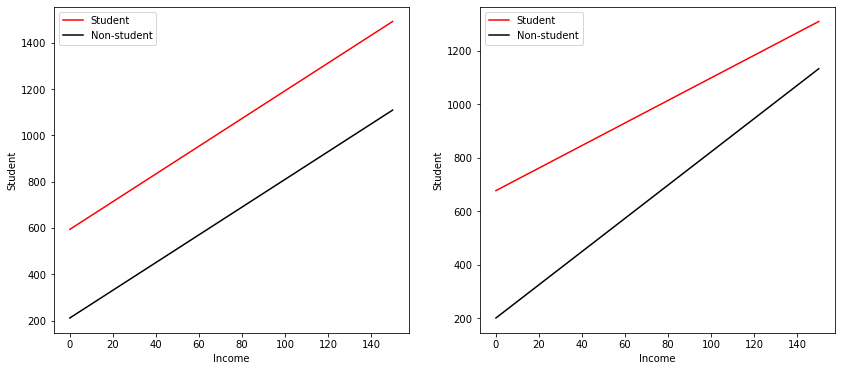

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

x = np.linspace(0, 150, 100)

y1 = res1.params[0] + res1.params[1] + x*res1.params[2]
y2 = res1.params[0] + x*res1.params[2]
axes[0].plot(x, y1, 'r-', label='Student')
axes[0].plot(x, y2, 'k-', label='Non-student')
axes[0].set(xlabel='Income', ylabel='Student')
axes[0].legend(loc='best')

y3 = res2.params[0] + x*res2.params[2]
y4 = res2.params[0] + res2.params[1] + x*(res2.params[2] + res2.params[3])
axes[1].plot(x, y4, 'r-', label='Student')
axes[1].plot(x, y3, 'k-', label='Non-student')
axes[1].set(xlabel='Income', ylabel='Student')
axes[1].legend(loc='best');

### Figure 3.8

In [48]:
# NA values are marked with '?'. If not marked as such,
# pandas will convert the whole column into strings.
filename = '../data/auto.csv'
auto_df = pd.read_csv(filename, na_values='?', index_col=-1)
# NA values are consequently dropped here
auto_df.dropna(inplace=True)

In [49]:
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150.0,3433,12.0,70,1
ford torino,17.0,8,302.0,140.0,3449,10.5,70,1


In [50]:
auto_df.describe().applymap('{:.2f}'.format)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.00,392.00,392.00,392.00,392.00,392.00,392.00,392.00
mean,23.45,5.47,194.41,104.47,2977.58,15.54,75.98,1.58
std,7.81,1.71,104.64,38.49,849.40,2.76,3.68,0.81
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.00,4.00,105.00,75.00,2225.25,13.78,73.00,1.00
50%,22.75,4.00,151.00,93.50,2803.50,15.50,76.00,1.00
75%,29.00,8.00,275.75,126.00,3614.75,17.02,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


In [51]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 27.6+ KB


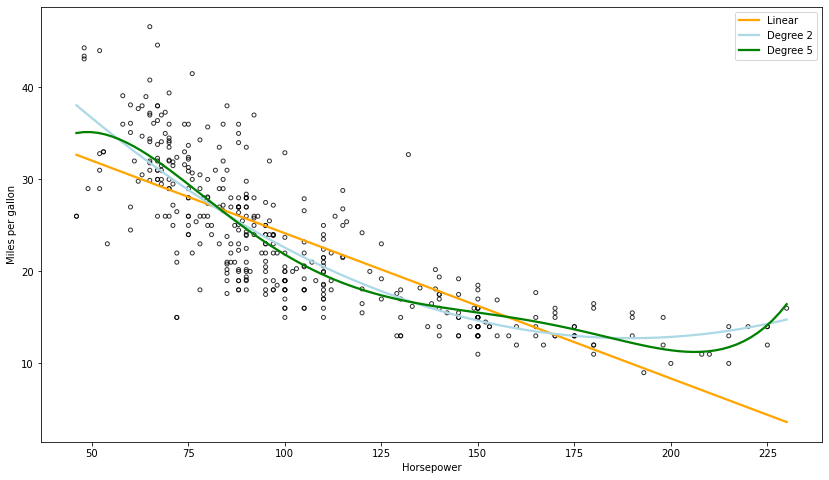

In [52]:
fig, axes = plt.subplots(figsize=(14, 8))
axes.scatter(auto_df['horsepower'], auto_df['mpg'], facecolors='None', edgecolors='k', s=16, label='', alpha=0.8)
sns.regplot(x='horsepower', y='mpg', data=auto_df, ci=None, scatter=False, order=1, label='Linear', color='orange')
sns.regplot(x='horsepower', y='mpg', data=auto_df, ci=None, scatter=False, order=2, label='Degree 2', color='lightblue')
sns.regplot(x='horsepower', y='mpg', data=auto_df, ci=None, scatter=False, order=5, label='Degree 5', color='green')
axes.set_xlabel('Horsepower')
axes.set_ylabel('Miles per gallon')
axes.legend(loc='best');

### Table 3.10

In [53]:
auto_df['horsepower2'] = auto_df['horsepower']**2

In [54]:
y_qf, X_qf = dmatrices('mpg ~ horsepower + horsepower2', data=auto_df, return_type='dataframe')
res_qf = sm.OLS(y_qf, X_qf).fit()
res_qf.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
horsepower2,0.0012,0.000,10.080,0.000,0.001,0.001


### Figure 3.9

In [55]:
data_fits = []
X1, y = auto_df['horsepower'].values.reshape(-1, 1), auto_df['mpg'].values.reshape(-1, 1)
regr = lm.LinearRegression()
regr.fit(X1, y)
print("R-squared for linear fit: {:1.4f}".format(r2_score(y, regr.predict(X1))))
y1_resid = y - regr.predict(X1)
data_fits.append((regr.predict(X1), y1_resid))
X2 = auto_df[['horsepower', 'horsepower2']].values
regr = lm.LinearRegression()
regr.fit(X2, y)
print("R-squared for quadratic fit: {:1.4f}".format(r2_score(y, regr.predict(X2))))
y2_resid = y - regr.predict(X2)
data_fits.append((regr.predict(X2), y2_resid))

R-squared for linear fit: 0.6059
R-squared for quadratic fit: 0.6876


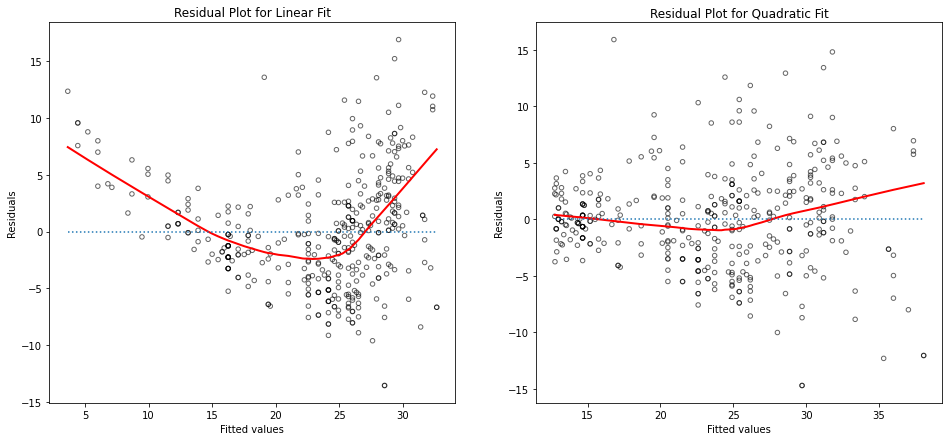

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
titles = ['Residual Plot for Linear Fit', 'Residual Plot for Quadratic Fit']
for i, ax, data in zip(range(2), axes, data_fits):
    sns.regplot(x=data[0].ravel(), y=data[1].ravel(), ci=None, lowess=True, \
                scatter_kws={'facecolors':'None', 'edgecolors':'k', 's':20, 'alpha':0.6}, \
                line_kws={'lw': 2, 'color':'r'}, ax=ax)
    ax.hlines(0, ax.xaxis.get_data_interval()[0], ax.xaxis.get_data_interval()[1], linestyles=':')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
    ax.set_title(titles[i]);

### Figure 3.14

In [57]:
credit_df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


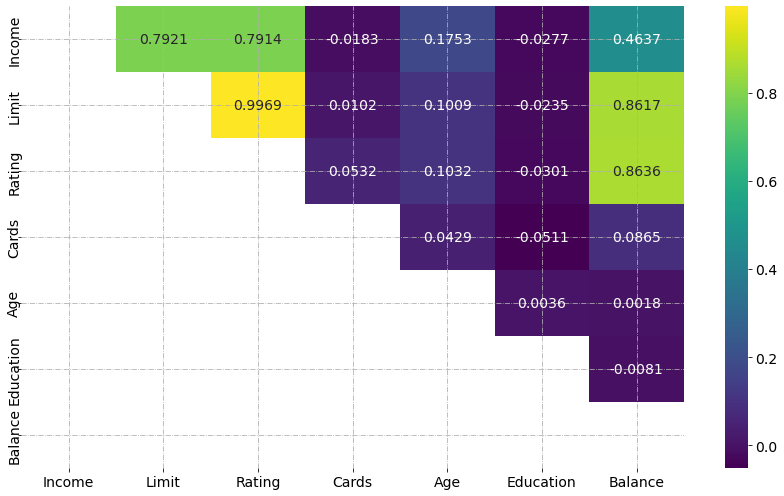

In [58]:
fig, axes = plt.subplots(figsize=(12, 7))
fs = 14
mask = np.zeros_like(credit_df.corr())
mask[np.tril_indices_from(mask)] = True
hm = sns.heatmap(data=credit_df.corr(), cmap='viridis', ax=axes, annot=True, fmt='1.4f', mask=mask, \
                 annot_kws={'size':fs})
axes.tick_params(labelsize=fs)
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=fs)
plt.setp(axes.get_yticklabels(), ha="center", rotation_mode="anchor")
plt.tight_layout()
plt.grid(True, linestyle='-.');

Text(0, 0.5, 'Rating')

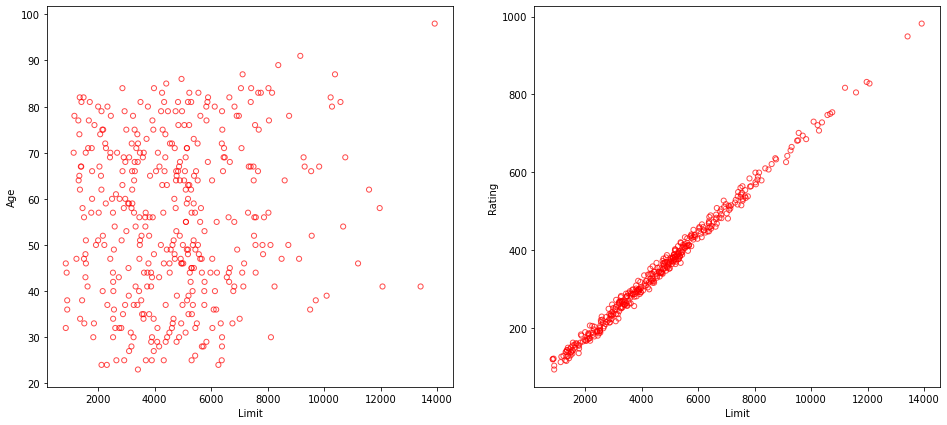

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
axes[0].scatter(credit_df.Limit.values, credit_df.Age.values, facecolor='None', s=26, edgecolor='r', alpha=0.7)
axes[0].set_xlabel('Limit')
axes[0].set_ylabel('Age')
axes[1].scatter(credit_df.Limit.values, credit_df.Rating.values, facecolor='None', s=26, edgecolor='r', alpha=0.7)
axes[1].set_xlabel('Limit')
axes[1].set_ylabel('Rating')

### Table 3.11

In [60]:
y, X = dmatrices('Balance ~ Age + Limit', data=credit_df, return_type='dataframe')
res = sm.OLS(y, X).fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-173.4109,43.828,-3.957,0.000,-259.576,-87.246
Age,-2.2915,0.672,-3.407,0.001,-3.614,-0.969
Limit,0.1734,0.005,34.496,0.000,0.163,0.183


In [61]:
y, X = dmatrices('Balance ~ Rating + Limit', data=credit_df, return_type='dataframe')
res = sm.OLS(y, X).fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-377.5368,45.254,-8.343,0.000,-466.505,-288.569
Rating,2.2017,0.952,2.312,0.021,0.330,4.074
Limit,0.0245,0.064,0.384,0.701,-0.101,0.150


### Figure 3.15

In [62]:
credit_df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [63]:
regr1 = lm.LinearRegression()
y = credit_df['Balance'].values
X1 = credit_df[['Limit', 'Age']].values
print('y', y.shape)
print('X1', X1.shape)
regr1.fit(scale(X1.astype('float'), with_std=False), y)
print('Intercept: {:1.3f}'.format(regr1.intercept_))
print('Limit: {:1.6f}'.format(regr1.coef_[0]))
print('Age: {:1.6f}'.format(regr1.coef_[1]))

y (400,)
X1 (400, 2)
Intercept: 520.015
Limit: 0.173365
Age: -2.291486


In [64]:
X_sclim = scale(credit_df['Limit'].astype('float'), with_std=False)
X_scage = scale(credit_df['Age'].astype('float'), with_std=False)
X_scrat = scale(credit_df['Rating'].astype('float'), with_std=False)

In [65]:
lim1 = np.linspace(regr1.coef_[0]-0.02, regr1.coef_[0]+0.02, 100) # Limit
age = np.linspace(regr1.coef_[1]-3, regr1.coef_[1]+3, 100) # Age
x1, y1 = np.meshgrid(lim1, age, indexing='xy')
print('x1', x1.shape)
print('y1', y1.shape)
z1 = np.zeros((age.size, lim1.size))
print('z1', z1.shape)
for (i, j), v in np.ndenumerate(z1):
    z1[i, j] = np.sum((y - (regr1.intercept_ + x1[i, j]*X_sclim + y1[i, j]*X_scage))**2)/1000000

x1 (100, 100)
y1 (100, 100)
z1 (100, 100)


In [66]:
regr2 = lm.LinearRegression()
y = credit_df['Balance'].values
X2 = credit_df[['Limit', 'Rating']].values
regr2.fit(scale(X2.astype('float'), with_std=False), y)
print('Intercept: {:1.3f}'.format(regr2.intercept_))
print('Limit: {:1.6f}'.format(regr2.coef_[0]))
print('Rating: {:1.6f}'.format(regr2.coef_[1]))

Intercept: 520.015
Limit: 0.024514
Rating: 2.201672


In [67]:
lim2 = np.linspace(regr2.coef_[0]-0.2, regr2.coef_[0]+0.2, 100) # Limit
rat = np.linspace(regr2.coef_[1]-3, regr2.coef_[1]+3, 100) # Rating
x2, y2 = np.meshgrid(lim2, rat, indexing='xy')
print('x2', x2.shape)
print('y2', y2.shape)
z2 = np.zeros((rat.size, lim2.size))
for (i, j), v in np.ndenumerate(z2):
    z2[i, j] = np.sum((y - (regr2.intercept_ + x2[i, j]*X_sclim + y2[i, j]*X_scrat))**2)/1000000
print('z2', z2.shape)

x2 (100, 100)
y2 (100, 100)
z2 (100, 100)


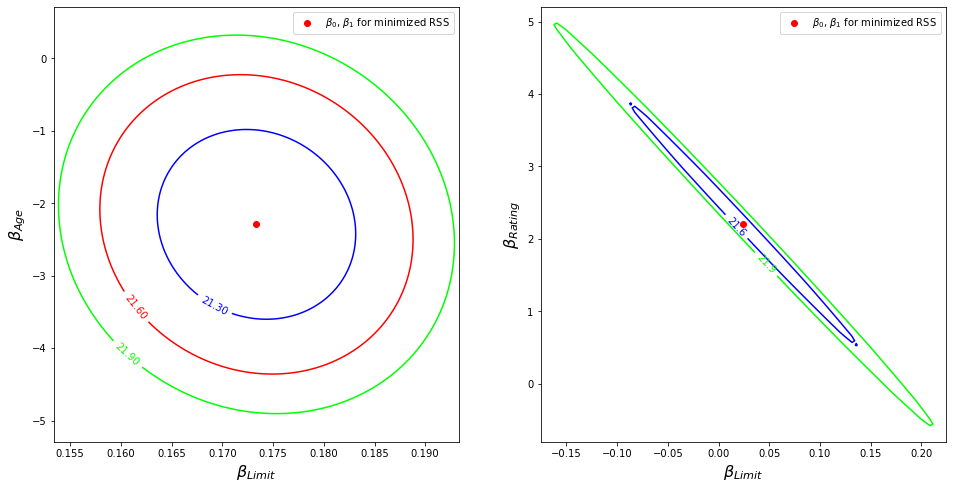

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'

cs1 = ax1.contour(x1, y1, z1, cmap=plt.cm.brg, levels=[21.3, 21.6, 21.9])
ax1.scatter(regr1.coef_[0], regr1.coef_[1], c='r', label=min_RSS)
ax1.clabel(cs1, inline=True, fontsize=10, fmt='%1.2f')
ax1.set_ylabel(r'$\beta_{Age}$', fontsize=16)

cs2 = ax2.contour(x2, y2, z2, cmap=plt.cm.brg, levels=[21.6, 21.9])
ax2.scatter(regr2.coef_[0], regr2.coef_[1], c='r', label=min_RSS)
ax2.clabel(cs2, inline=True, fontsize=10, fmt='%1.1f')
ax2.set_ylabel(r'$\beta_{Rating}$', fontsize=16)

for ax in (ax1, ax2):
    ax.set_xlabel(r'$\beta_{Limit}$', fontsize=16)
    ax.legend(loc='best');

### Variance inflation factors

In [69]:
y, X1 = dmatrices('Age ~ Rating + Limit', return_type='dataframe', data=credit_df)
res1 = sm.OLS(y, X1).fit()
y, X2 = dmatrices('Rating ~ Age + Limit', return_type='dataframe', data=credit_df)
res2 = sm.OLS(y, X2).fit()
y, X3 = dmatrices('Limit ~ Rating + Age', return_type='dataframe', data=credit_df)
res3 = sm.OLS(y, X3).fit()
print('VIF for Age: {:1.2f}'.format(1/(1 - res1.rsquared)))
print('VIF for Rating: {:1.2f}'.format(1/(1 - res2.rsquared)))
print('VIF for Limit: {:1.2f}'.format(1/(1 - res3.rsquared)))

VIF for Age: 1.01
VIF for Rating: 160.67
VIF for Limit: 160.59
